In [29]:
# Necessary imports
%reload_ext autoreload

import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sps

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.visualization.plot_data import matrix_heatmap, plot_coo_matrix

import seaborn
import matplotlib.pyplot as plt

# Import the TCGA cancer data

In [19]:
degrees = network.G.degree(nbunch=network.nodes["LNC"])
degrees_num = [degree for node, degree in degrees]
len(degrees_num)

1794

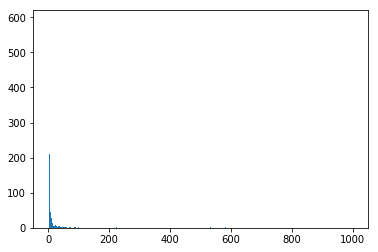

In [20]:
plt.hist(degrees_num, bins=1000, range=(0, 1000))
plt.show()

In [22]:
LNC = network.multi_omics_data.LNC.get_genes_info()

In [23]:
LNC[~LNC["Transcript sequence"].isnull()]["Transcript Type"].value_counts()

lincRNA                     4227
antisense                   2922
processed transcript        1122
sense_intronic               273
sense_overlapping             91
non_coding                    83
retained intron               16
ambiguous_orf                 14
3prime_overlapping_ncrna       6
TEC                            4
Name: Transcript Type, dtype: int64

In [3]:
folder_path = "/home/jonny/PycharmProjects/Bioinformatics_ExternalData/tcga-assembler/LUAD/"
external_data_path = "/home/jonny/PycharmProjects/Bioinformatics_ExternalData/"
luad_data = MultiOmicsData(cancer_type="LUAD", tcga_data_path=folder_path, external_data_path=external_data_path,
                           modalities=[\
                                       "GE",
                                       "MIR",
                                       "LNC",
                                       # "CNV",
                                       # "SNP",
#                                        "PRO",
                                       # "DNA"
                                       ])

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


PATIENTS (522, 110)
DRUGS (461, 4)
GE (576, 20284)
MIR (494, 1870)
LNC (546, 12727)
SAMPLES (599, 111)
Processed genes info for  GE
Processed genes info for  MIR


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:686: FutureWarning: 'MiRBase ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  self.gene_info = self.gene_info.join(self.targetScan_family_df.groupby("MiRBase ID").first(), on="MiRBase ID",how="left")
/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:356: FutureWarning: 'symbol' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  self.gene_info = self.gene_info.join(self.HGNC_lncrna_info.groupby("symbol").first(), on="symbol",
/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/pandas/core/frame.py:6336: FutureWarning: 'Gene Name' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  rsuffix=rsuffix, sort=sort)


Processed genes info for  LNC


# Heterogeneous Network

In [25]:
import pickle
with open('moge/data/LMN_only_directed/lmn_miRTarBase_BioGRID_lncBase_lncRNome_LncReg.pickle', 'rb') as file:
    network = pickle.load(file)

In [30]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=luad_data)

## Write node labels to file

In [7]:
# READ Edgeslist
network.import_edgelist_file(file="lncRNA-miRNA-mRNA_new-08-14.edgelist", 
                             is_directed=True)

In [16]:
# WRITE Edgelist
nx.write_edgelist(network_train.get_subgraph(["MIR", "GE", "LNC"]), 
                  "moge/data/lncRNA_miRNA_mRNA/lmn_network_filtered_directed.edgelist", 
                  data=False)

In [4]:
from moge.network.file_io import write_node_labels_to_file

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_family.tsv", luad_data, 
#                           label_cols=["family"],
#                           modalities=["MIR", "GE", "LNC"], 
#                           get_dummies=False)

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_disease_dummies.tsv", luad_data, 
#                           label_cols=["Disease association"],
#                           modalities=["MIR", "GE", "LNC"], remove_na=True, sep="\t",
#                           get_dummies=True)

# Add Attribute Affinity Positive Edges

In [4]:
affinities_GE = network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
                                        similarity_threshold=0.80, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=2.0,
                                        features=["locus_type", "gene_family_id"], 
                                        compute_correlation=False)

Gower's dissimilarity: Computing locus_type , dtype: object , shape: (20284,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing gene_family_id , dtype: object , shape: (20284,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing location , dtype: object , shape: (20284,)
Location split to Chromosome, arm, region
Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (20284,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing arm , dtype: object , shape: (20284,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing region , dtype: object , shape: (20284,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:155: RuntimeWarning: invalid value encountered in greater_equal
  X[i][np.where(X[i-1] >= X[i])] = X[i-1][np.where(X[i-1] >= X[i])] # the distance of child feature is only as great as distance of parent features
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:157: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=0)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:144: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


247533 undirected positive edges (type='u') added.
495066 undirected negative edges (type='u_n') added.


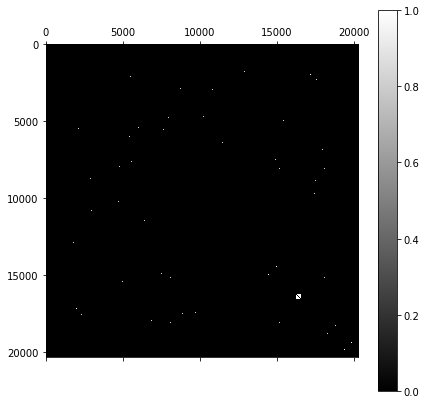

In [7]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["GE"]).todense(),
              figsize=(7,7))

In [5]:
affinities_MIR = network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
                                        similarity_threshold=0.80, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=2.0,
                                        features=["miR family", "location"], 
                                        compute_correlation=False)

Gower's dissimilarity: Computing miR family , dtype: object , shape: (1870,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing location , dtype: object , shape: (1870,)
Location split to Chromosome, arm, region
Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (1870,)
Dice distance
Gower's dissimilarity: Computing arm , dtype: object , shape: (1870,)
Dice distance
Gower's dissimilarity: Computing region , dtype: object , shape: (1870,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


545 undirected positive edges (type='u') added.
1090 undirected negative edges (type='u_n') added.


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:155: RuntimeWarning: invalid value encountered in greater_equal
  X[i][np.where(X[i-1] >= X[i])] = X[i-1][np.where(X[i-1] >= X[i])] # the distance of child feature is only as great as distance of parent features
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:157: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=0)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:144: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


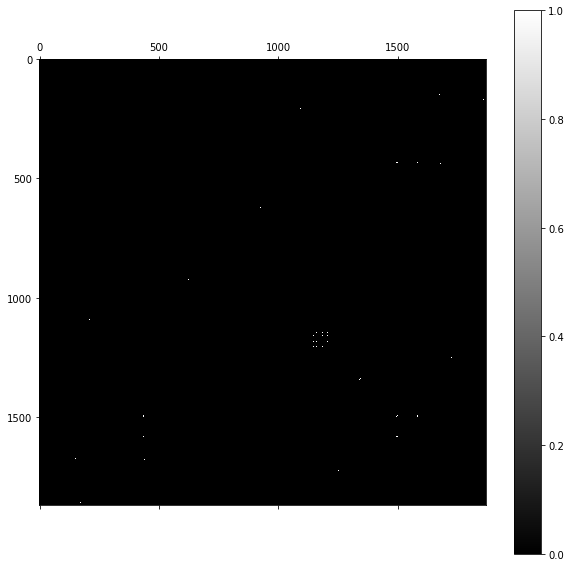

In [8]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["MIR"]).todense(),
              figsize=(10,10))

In [6]:
affinities_LNC = network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
                                        similarity_threshold=0.80, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=2.0,
                                        features=["Transcript Type", "Location", "Strand"], 
                                        compute_correlation=False)

Gower's dissimilarity: Computing Transcript Type , dtype: object , shape: (12725,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Location , dtype: object , shape: (12725,)
Location split to Chromosome, start, end
Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (12725,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing start , dtype: float64 , shape: (12725,)
Euclidean distance (normalized ptp)


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:155: RuntimeWarning: invalid value encountered in greater_equal
  X[i][np.where(X[i-1] >= X[i])] = X[i-1][np.where(X[i-1] >= X[i])] # the distance of child feature is only as great as distance of parent features
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:157: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=0)
/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Strand , dtype: object , shape: (12725,)
Dice distance


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:144: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


399158 undirected positive edges (type='u') added.
798316 undirected negative edges (type='u_n') added.


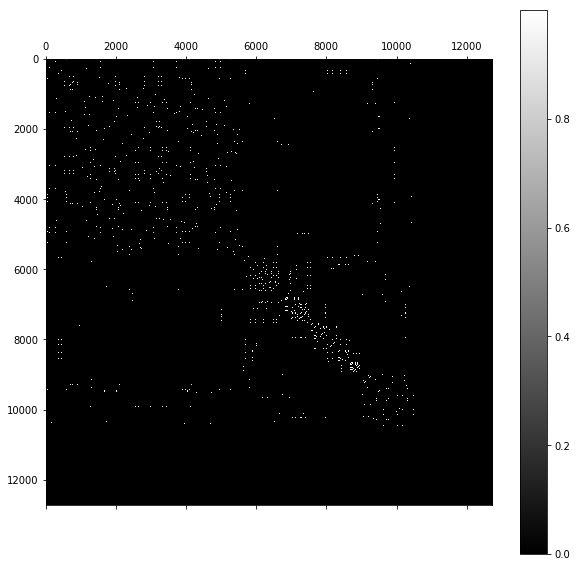

In [9]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["LNC"]).todense(),
              figsize=(10,10))

In [13]:
network.G.number_of_edges()

1917502

# Add Attribute Affinity NEGATIVE Edges between cross-modals

In [11]:
u_n_size = 10000
network.add_sampled_negative_edges(u_n_size, modalities=["GE", "MIR"])
network.add_sampled_negative_edges(u_n_size*2, modalities=["GE", "LNC"])
network.add_sampled_negative_edges(u_n_size, modalities=["LNC", "MIR"])

Number of negative sampled edges between ['GE', 'MIR'] added: 10000
Number of negative sampled edges between ['GE', 'LNC'] added: 20000
Number of negative sampled edges between ['LNC', 'MIR'] added: 10000


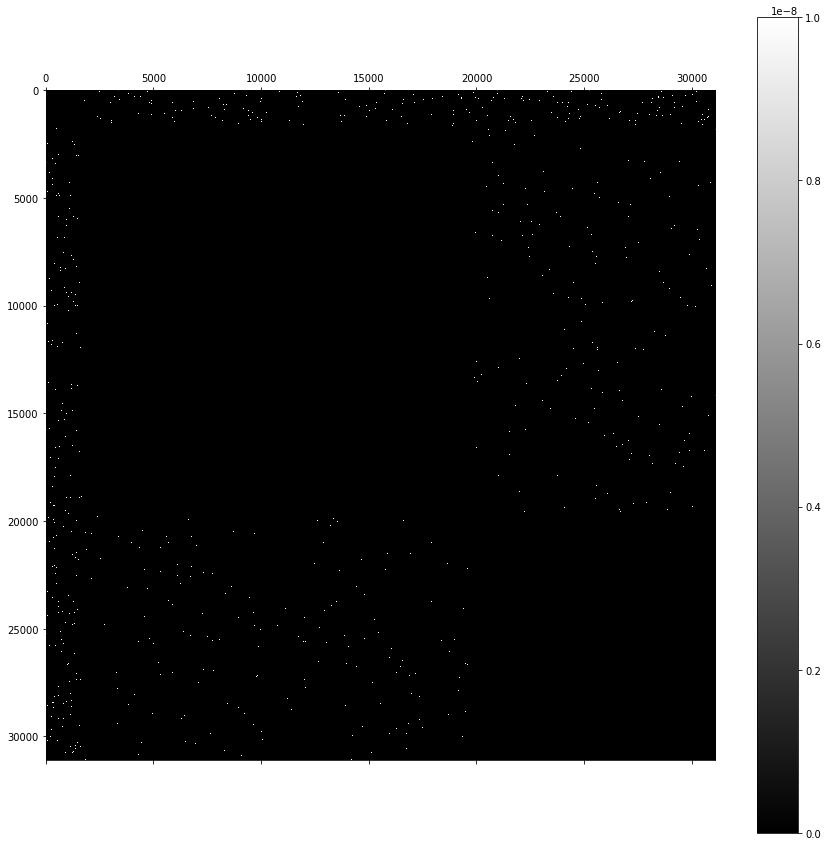

In [31]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list).todense(),
              figsize=(15,15))

# Add Regulatory Interaction edges

In [6]:
# Adds miRNA-target interaction network
network.add_directed_edges_from_edgelist(edgelist=luad_data.MIR.get_miRTarBase_miRNA_target_interaction(), 
                                        modalities=["MIR", "GE"], correlation_weights=False, threshold=0.20)

Adding edgelist with 1759 total unique MIR genes (source), but only matching 1618 nodes
Adding edgelist with 15064 total unique GE genes (target), but only matching 14673 nodes
377318 edges added.


In [7]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=luad_data.GE.get_BioGRID_GRN_edgelist(), # unweighted edges
                                         modalities=["GE", "GE"], correlation_weights=False, threshold=0.65)

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3189: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Adding edgelist with 13318 total unique GE genes (source), but only matching 12775 nodes
Adding edgelist with 19429 total unique GE genes (target), but only matching 14995 nodes
313724 edges added.


In [8]:
# Adds miRNA-lncRNA interaction network
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_miRNA_interactions_edgelist(),
#                                         )
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRNome_miRNA_binding_sites_edgelist(),
                                         modalities=["LNC", "MIR"], correlation_weights=False, threshold=0.20)

network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncBase_miRNA_lncRNA_interactions_edgelist(),
                                         modalities=["MIR", "LNC"], correlation_weights=False, threshold=0.20)

network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_LncReg_lncRNA_RNA_regulatory_interactions(),
                                         modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20)

Adding edgelist with 66 total unique LNC genes (source), but only matching 31 nodes
Adding edgelist with 978 total unique MIR genes (target), but only matching 893 nodes
2375 edges added.
Adding edgelist with 702 total unique MIR genes (source), but only matching 631 nodes
Adding edgelist with 6185 total unique LNC genes (target), but only matching 1760 nodes
53926 edges added.
Adding edgelist with 137 total unique LNC genes (source), but only matching 19 nodes
Adding edgelist with 373 total unique GE genes (target), but only matching 172 nodes
554 edges added.


# Filter the node_list

In [9]:
isolates = list(nx.isolates(network.G))

In [10]:
network.nodes["GE"] = [node for node in network.nodes["GE"] if node not in isolates]
network.nodes["LNC"] = [node for node in network.nodes["LNC"] if node not in isolates]
network.nodes["MIR"] = [node for node in network.nodes["MIR"] if node not in isolates]
network.node_list = [node for node in network.node_list if node not in isolates]

In [11]:
# network.remove_extra_nodes() # Also makes network unmutable

In [12]:
network.G.number_of_nodes()

43928

In [13]:
len(network.node_list)

21115

In [15]:
# Write FULL network
import pickle
with open('moge/data/LMN_only_directed/lmn_miRTarBase_BioGRID_lncBase_lncRNome_LncReg.pickle', 'wb') as file:
    pickle.dump(network, file)

# Split train-test

In [14]:
network.G.number_of_edges()

747850

In [27]:
from moge.evaluation.utils import split_train_test_edges, split_train_test_nodes

network_train, val_edges_dict, test_edges_dict = split_train_test_edges(network, 
                                                                                               network.node_list, 
                                                          test_frac=.00, val_frac=.10, edge_types=["d"], 
                                                          seed=0, verbose=False)

Removed 0 test, and 63962 val, type d edges


In [17]:
network_train.G.number_of_edges()

615465

In [31]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network_test = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_val = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_test.node_list = test_nodes
network_val.node_list = val_nodes

MIR  nodes: 1870
GE  nodes: 20284
LNC  nodes: 12725
Total nodes: 34879
MIR  nodes: 1870
GE  nodes: 20284
LNC  nodes: 12725
Total nodes: 34879


NameError: name 'test_nodes' is not defined

In [32]:
len(network_test.node_list), len(network_val.node_list)

(34879, 34879)

In [33]:
node_list = network_train.node_list
for edge_type, edges in test_edges_dict.items():
    for edge in edges:
        network_test.G.add_edge(node_list[edge[0]], node_list[edge[1]], type=edge_type) # for split edges
#         network_test.G.add_edge(edge[0], edge[1], type=edge_type) # for split nodes
print(network_test.G.number_of_edges())

for edge_type, edges in val_edges_dict.items():
    for edge in edges:
        network_val.G.add_edge(node_list[edge[0]], node_list[edge[1]], type=edge_type) # for split edges
#         network_val.G.add_edge(edge[0], edge[1], type=edge_type) # For split nodes
print(network_val.G.number_of_edges())

0
63962


In [34]:
# WRITE
import pickle
with open('moge/data/LMN_only_directed/lmn_edges10_train.pickle', 'wb') as file:
    pickle.dump(network_train, file)
    
with open('moge/data/LMN_only_directed/lmn_edges10_test.pickle', 'wb') as file:
    pickle.dump(network_test, file)
    
with open('moge/data/LMN_only_directed/lmn_edges10_val.pickle', 'wb') as file:
    pickle.dump(network_val, file)

## Network Info & Visualizations

In [22]:
print(len(network.G.nodes()))
print(len(network.G.edges()))

33120
1243116


In [23]:
csr_un = network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list)
csr_u = network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list)
csr_d = network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list)

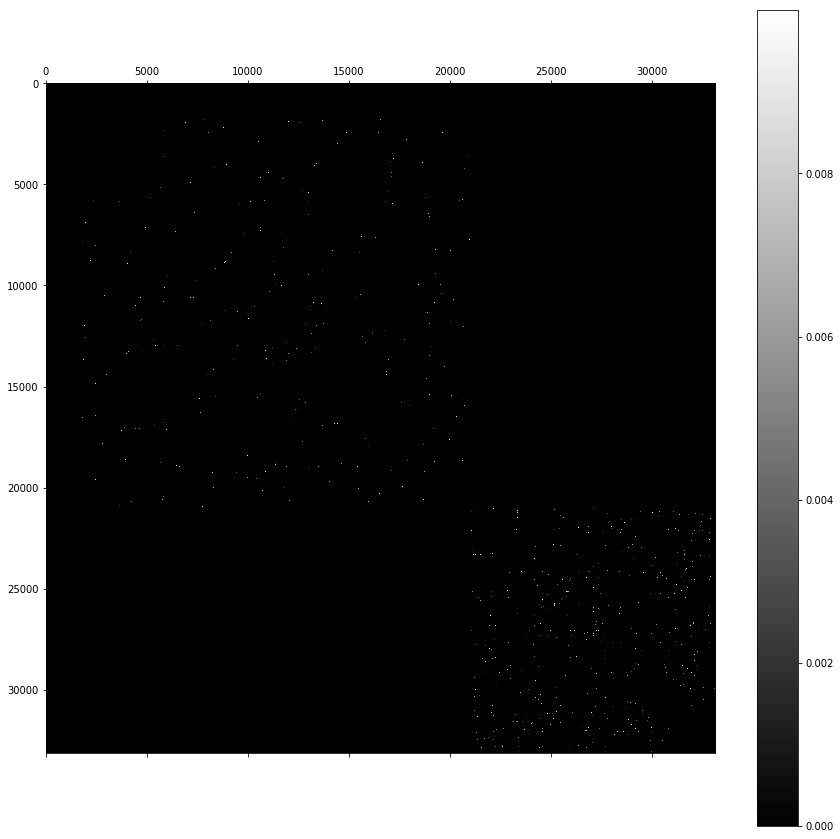

In [24]:
matrix_heatmap(csr_un.toarray())

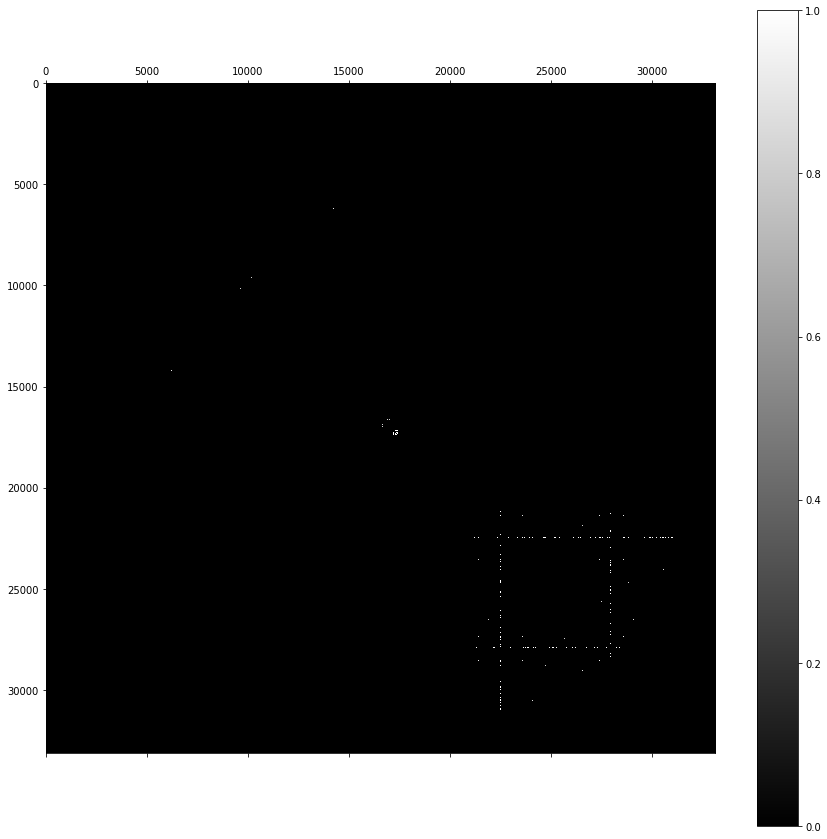

In [25]:
matrix_heatmap(csr_u.toarray())

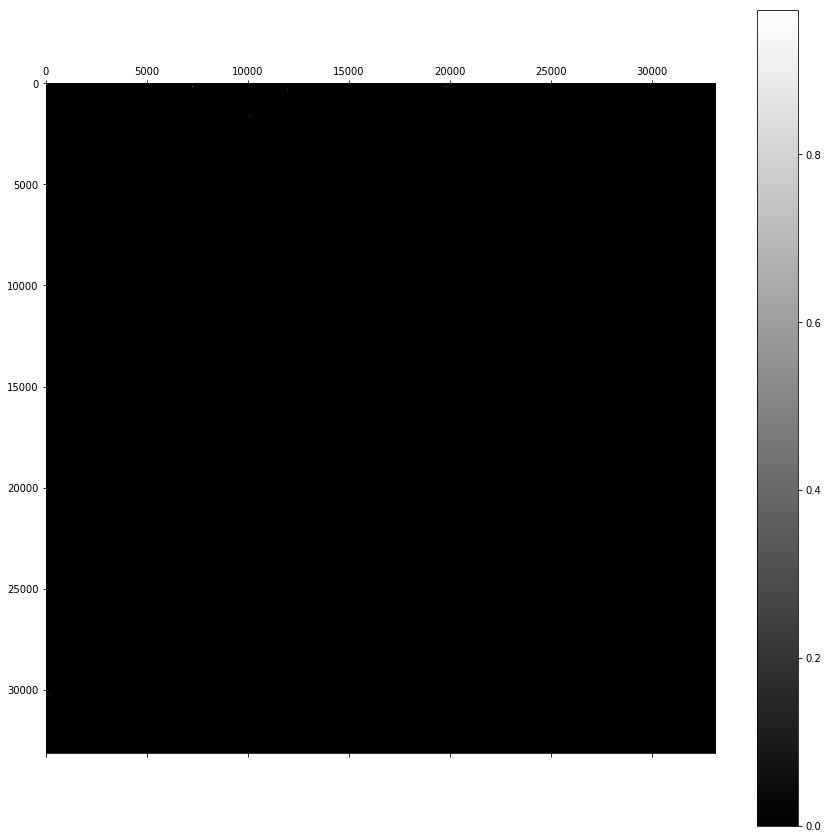

In [26]:
matrix_heatmap(csr_d.toarray())